# Langgraph Controllability Concepts

In [103]:
from dotenv import load_dotenv

load_dotenv()

True

In [104]:
from langchain_google_genai import GoogleGenerativeAI
llm = GoogleGenerativeAI(model="gemini-2.5-flash")

In [105]:
from typing import TypedDict

class State(TypedDict):
    state: str

In [106]:
def node_a(state: State) -> State:
    print('--Node A--')
    state['state']+='a'

def node_b(state: State) -> State:
    print('--Node B--')
    state['state']+='b'

def node_c(state: State) -> State:
    print('--Node C--')
    state['state']+='c'

def node_d(state: State) -> State:
    print('--Node D--')
    state['state']+='d'

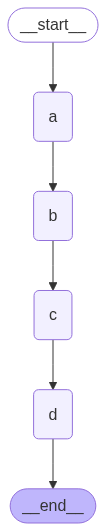

In [107]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
f_builder = StateGraph(State)

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State):
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
f_builder = StateGraph(State)

# Initialize each node with node_secret 
f_builder.add_node("a", ReturnNodeValue("I'm A"))
f_builder.add_node("b", ReturnNodeValue("I'm B"))
f_builder.add_node("c", ReturnNodeValue("I'm C"))
f_builder.add_node("d", ReturnNodeValue("I'm D"))

f_builder.add_edge(START, 'a')
f_builder.add_edge('a', 'b')
f_builder.add_edge('b', 'c')
f_builder.add_edge('c', 'd')
f_builder.add_edge('d', END)

graph = f_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [108]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

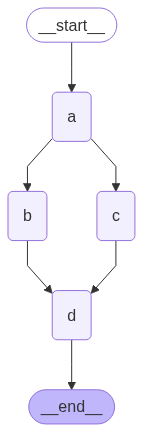

In [109]:
f_builder = StateGraph(State)

# Initialize each node with node_secret 
f_builder.add_node("a", ReturnNodeValue("I'm A"))
f_builder.add_node("b", ReturnNodeValue("I'm B"))
f_builder.add_node("c", ReturnNodeValue("I'm C"))
f_builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
f_builder.add_edge(START, "a")
f_builder.add_edge("a", "b")
f_builder.add_edge("a", "c")
f_builder.add_edge("b", "d")
f_builder.add_edge("c", "d")
f_builder.add_edge("d", END)
graph = f_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [110]:
graph.invoke({'state': []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]


InvalidUpdateError: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

### use reducers to overcome this

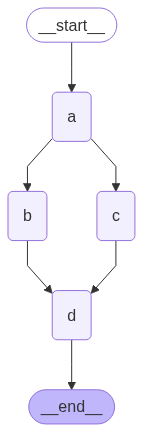

In [111]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
f_builder = StateGraph(State)

# Initialize each node with node_secret 
f_builder.add_node("a", ReturnNodeValue("I'm A"))
f_builder.add_node("b", ReturnNodeValue("I'm B"))
f_builder.add_node("c", ReturnNodeValue("I'm C"))
f_builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
f_builder.add_edge(START, "a")
f_builder.add_edge("a", "b")
f_builder.add_edge("a", "c")
f_builder.add_edge("b", "d")
f_builder.add_edge("c", "d")
f_builder.add_edge("d", END)
graph = f_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [112]:
graph.invoke({'state': []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

### wait for nodes to settle

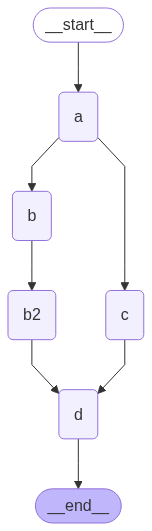

In [113]:
f_builder = StateGraph(State)

# Initialize each node with node_secret 
f_builder.add_node("a", ReturnNodeValue("I'm A"))
f_builder.add_node("b", ReturnNodeValue("I'm B"))
f_builder.add_node("b2", ReturnNodeValue("I'm B2"))
f_builder.add_node("c", ReturnNodeValue("I'm C"))
f_builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
f_builder.add_edge(START, "a")
f_builder.add_edge("a", "b")
f_builder.add_edge("a", "c")
f_builder.add_edge("b", "b2")
f_builder.add_edge(["b2", "c"], "d")
f_builder.add_edge("d", END)
graph = f_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [114]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

### set custom order of execution

#### how? using custom reducer

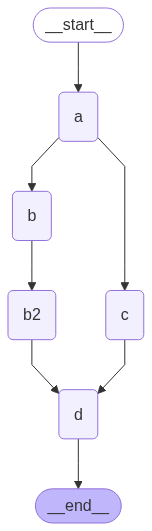

In [115]:
def asc_sort_reducer(left, right):
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    state: Annotated[list, asc_sort_reducer]

f_builder = StateGraph(State)

f_builder.add_node("a", ReturnNodeValue("I'm A"))
f_builder.add_node("b", ReturnNodeValue("I'm B"))
f_builder.add_node("b2", ReturnNodeValue("I'm B2"))
f_builder.add_node("c", ReturnNodeValue("I'm C"))
f_builder.add_node("d", ReturnNodeValue("I'm D"))

f_builder.add_edge(START, "a")
f_builder.add_edge("a", "b")
f_builder.add_edge("a", "c")
f_builder.add_edge("b", "b2")
f_builder.add_edge(["b2", "c"], "d")
f_builder.add_edge("d", END)
graph = f_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [116]:
graph.invoke({'state': []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

### With LLM

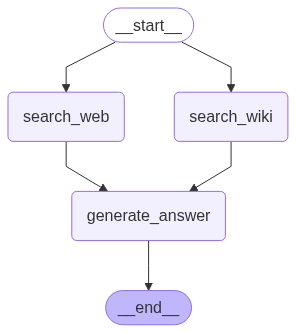

In [117]:
from IPython.display import Image, display
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]


from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """
    print('--Search Web--')

    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

    return {"context": [''.join([
        f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
        for doc in search_docs
    ])]} 

def search_wiki(state):
    print('--Search Wikipedia--')

    search_docs = WikipediaLoader(query=state['question'], load_max_docs=3).load()

    return {"context": [''.join([
        f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
        for doc in search_docs
    ])]} 


def generate_answer(state):
    
    print('--Generate Answer--')

    context = state["context"]
    question = state["question"]

    answer_template = """Upon searching the web and Wikipedia for {question}, I have gathered some context: {context}."""
    answer_instructions = answer_template.format(question=question, context=context)

    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
    
    return {"answer": answer}


f_builder = StateGraph(State)


f_builder.add_node("search_web",search_web)
f_builder.add_node("search_wiki", search_wiki)
f_builder.add_node("generate_answer", generate_answer)


f_builder.add_edge(START, "search_wiki")
f_builder.add_edge(START, "search_web")
f_builder.add_edge("search_wiki", "generate_answer")
f_builder.add_edge("search_web", "generate_answer")
f_builder.add_edge("generate_answer", END)
f_builder.set_entry_point("search_wiki")
graph = f_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [120]:
from IPython.display import Markdown
result = graph.invoke({"question": "What are OpenAI's models and release notes as of Jul 2025?"})
Markdown(result['answer'])

--Search Web--
--Search Wikipedia--
--Generate Answer--


As of July 2025, OpenAI has released or made improvements to the following models:

**Released in 2024:**
*   **OpenAI o1:** A reasoning model that generates long chains of thought before returning a final answer.

**Released in 2025:**
*   **OpenAI o3-mini:** Released on January 31, 2025.
*   **GPT-4.5:** Released on February 27, 2025. After July 2025, it will only be available through ChatGPT for Plus and Pro subscribers. It is noted as OpenAI's best GPT model, outperforming GPT-4o.
*   **OpenAI o3 and o4-mini:** Released on April 16, 2025.
*   **Latest image generation model in the API:** Released on April 23, 2025.
*   **Improvements to GPT-4o:** Released on April 25, 2025, optimizing memory saving and enhancing STEM problem-solving capabilities, making it more proactive and intuitive.
*   **Codex:** Released on May 16, 2025.
*   **OpenAI o3-pro:** Launched on June 10, 2025, available for Pro users in ChatGPT and the API.

Other models mentioned as existing but without specific 2025 release notes in the provided context include **GPT-4** (released 2023) and **GPT-4.1**.

### Subgraphs

In [121]:
from typing import TypedDict
from datetime import datetime

class News(TypedDict):
    field: str
    reports: list[str]
    is_breaking: bool

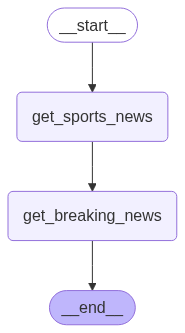

In [122]:
# Graph1: Sports News

# state
class SportsNewsState(TypedDict):
    news: list[News]
    air_date: datetime

# nodes
def get_latest_sports_news_node(state: SportsNewsState) -> SportsNewsState:
    state['news'] = [
        {
        'field': 'cricket',
        'reports': ['IND vs ENG 🏏...', '🏏 Test 3, day 3...'],
        'is_breaking': True
        }, 
        {
        'field': 'football',
        'reports': ['🏈 some news...', '⚽️...'],
        'is_breaking': False
        }
    ]
    state['air_date'] = datetime.now()
    return state


def get_breaking_news_node(state: SportsNewsState) -> SportsNewsState:
    breaking_news: list[News] = []
    print('--Get Breaking News--')
    print(f'All Sports News: {state["news"]}')
    for _ in state['news']:
        if _['is_breaking']:
            breaking_news.append(_)
    print(f"Sports Breaking news: {breaking_news}")
    state['news'] = breaking_news
    return state


# graph
s_builder = StateGraph(SportsNewsState)


s_builder.add_node("get_sports_news", get_latest_sports_news_node)
s_builder.add_node("get_breaking_news", get_breaking_news_node)


s_builder.add_edge(START, "get_sports_news")
s_builder.add_edge("get_sports_news", "get_breaking_news")
s_builder.add_edge("get_breaking_news", END)
graph = s_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

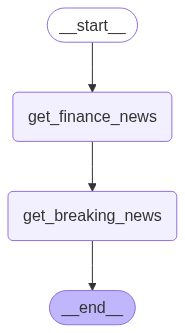

In [123]:
# Graph2: Finance News

# state
class FinanceNewsState(TypedDict):
    news: list[News]
    source: str

# nodes
def get_latest_finance_news_node(state: FinanceNewsState) -> FinanceNewsState:
    state['news'] = [
        {
        'field': 'stock',
        'reports': ['📉🐻...', '🐂📈...'],
        'is_breaking': True
        }, 
        {
        'field': 'trades',
        'reports': ['💰💶...', '💵💲...'],
        'is_breaking': False
        }
    ]
    state['source'] = 'WSJ'
    return state


def get_breaking_news_node(state: FinanceNewsState) -> FinanceNewsState:
    breaking_news: list[News] = []
    print('--Get Breaking News--')
    print(f'All Finance News: {state["news"]}')
    for _ in state['news']:
        if _['is_breaking']:
            breaking_news.append(_)
    print(f" Finance Breaking news: {breaking_news}")
    state['news'] = breaking_news
    return state


# graph
f_builder = StateGraph(FinanceNewsState)


f_builder.add_node("get_finance_news", get_latest_finance_news_node)
f_builder.add_node("get_breaking_news", get_breaking_news_node)


f_builder.add_edge(START, "get_finance_news")
f_builder.add_edge("get_finance_news", "get_breaking_news")
f_builder.add_edge("get_breaking_news", END)
graph = f_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

#### Combine Graphs to Parent Graph

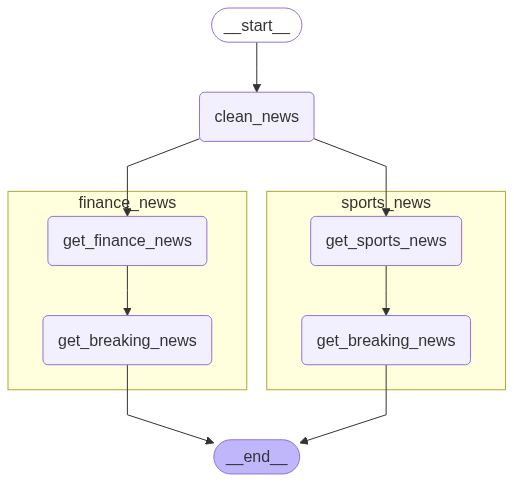

In [124]:
from typing import Annotated
from operator import add
class EntryGraphState(TypedDict):
    raw_news: list[News]
    cleaned_news: list[News]
    air_date: datetime # This will only be generated in the FA sub-graph
    source: str # This will only be generated in the QS sub-graph
    news:  Annotated[list[News], add] # This will be generated in BOTH sub-graphs

def clean_news(state):
    # Get logs
    raw_news = state["raw_news"]
    # Data cleaning raw_logs -> docs 
    cleaned_news = raw_news
    return {"cleaned_news": cleaned_news}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_news", clean_news)
entry_builder.add_node("sports_news", s_builder.compile())
entry_builder.add_node("finance_news", f_builder.compile())

entry_builder.add_edge(START, "clean_news")
entry_builder.add_edge("clean_news", "sports_news")
entry_builder.add_edge("clean_news", "finance_news")
entry_builder.add_edge("finance_news", END)
entry_builder.add_edge("sports_news", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [125]:
### create dummy sports news and finance news

sports_news = [
    {
        'field': 'cricket',
        'reports': ['IND vs ENG 🏏...', '🏏 Test Series 2023', '🏏 IPL 2023'],
        'is_breaking': True,
    },
    {
        'field': 'football',
        'reports': ['Champions League Final ⚽...', '⚽ Premier League Highlights', '⚽ La Liga Updates'],
        'is_breaking': False,
    },
    {
        'field': 'finance',
        'reports': ['Stock Market Crash 📉...', '📈 Cryptocurrency Trends', '📊 Economic Outlook 2023'],
        'is_breaking': False,
    },
]

finance_news = [
    {
        'field': 'stock',
        'reports': ['📉🐻 Bear Market Trends', '🐂📈 Bull Market Predictions', '💰💶 Investment Strategies'],
        'is_breaking': True,
    },
    {
        'field': 'trades',
        'reports': ['💵💲 Forex Trading Tips', '📊 Stock Analysis Tools', '📈 Market News'],
        'is_breaking': False,
    },
]

raw_news = sports_news + finance_news

In [126]:
# invoke the graph with the raw news
res= graph.invoke({
    "raw_news": raw_news
})
res


--Get Breaking News--
All Finance News: [{'field': 'stock', 'reports': ['📉🐻...', '🐂📈...'], 'is_breaking': True}, {'field': 'trades', 'reports': ['💰💶...', '💵💲...'], 'is_breaking': False}]
 Finance Breaking news: [{'field': 'stock', 'reports': ['📉🐻...', '🐂📈...'], 'is_breaking': True}]
--Get Breaking News--
All Sports News: [{'field': 'cricket', 'reports': ['IND vs ENG 🏏...', '🏏 Test 3, day 3...'], 'is_breaking': True}, {'field': 'football', 'reports': ['🏈 some news...', '⚽️...'], 'is_breaking': False}]
Sports Breaking news: [{'field': 'cricket', 'reports': ['IND vs ENG 🏏...', '🏏 Test 3, day 3...'], 'is_breaking': True}]


{'raw_news': [{'field': 'cricket',
   'reports': ['IND vs ENG 🏏...', '🏏 Test Series 2023', '🏏 IPL 2023'],
   'is_breaking': True},
  {'field': 'football',
   'reports': ['Champions League Final ⚽...',
    '⚽ Premier League Highlights',
    '⚽ La Liga Updates'],
   'is_breaking': False},
  {'field': 'finance',
   'reports': ['Stock Market Crash 📉...',
    '📈 Cryptocurrency Trends',
    '📊 Economic Outlook 2023'],
   'is_breaking': False},
  {'field': 'stock',
   'reports': ['📉🐻 Bear Market Trends',
    '🐂📈 Bull Market Predictions',
    '💰💶 Investment Strategies'],
   'is_breaking': True},
  {'field': 'trades',
   'reports': ['💵💲 Forex Trading Tips',
    '📊 Stock Analysis Tools',
    '📈 Market News'],
   'is_breaking': False}],
 'cleaned_news': [{'field': 'cricket',
   'reports': ['IND vs ENG 🏏...', '🏏 Test Series 2023', '🏏 IPL 2023'],
   'is_breaking': True},
  {'field': 'football',
   'reports': ['Champions League Final ⚽...',
    '⚽ Premier League Highlights',
    '⚽ La Liga Updates']